# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
for alpha in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss = svm.train(X_train_feats, y_train, learning_rate=alpha, reg=reg, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        y_val_accuracy = np.mean(y_val == y_val_pred)
        results[(alpha, reg)] = (y_train_accuracy, y_val_accuracy)
        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_svm = svm
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
[6 9 9 ..., 4 9 3]
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.088429 val accuracy: 0.082000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.114286 val accuracy: 0.119000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.123612 val accuracy: 0.109000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.089531 val accuracy: 0.077000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.350082 val accuracy: 0.318000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.414224 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.416184 val accuracy: 0.418000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.415184 val accuracy: 0.418000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.376878 val accuracy: 0.360000
best validation accuracy achieved during cross-validation: 0.418000


In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


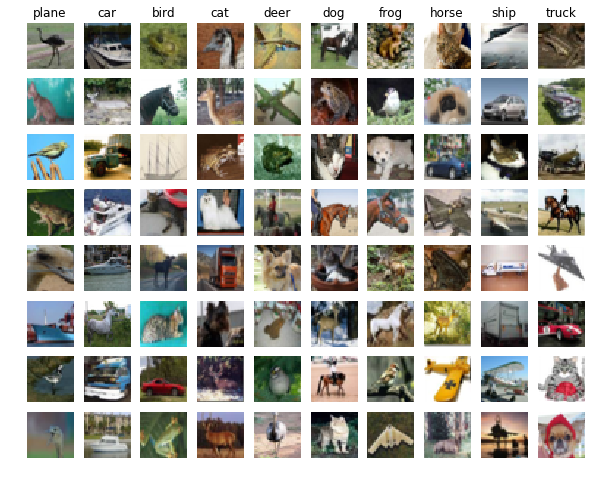

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 154)
(49000, 153)


In [23]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
num_iters = 15000
learning_rate_decay=0.95
best_val = -1
regs = [1e-5, 8e-4, 4e-2]
learning_rates = [0.5, 1]

for reg in regs:
    for alpha in learning_rates:
        print("using reg-",reg,"alpha-",alpha)
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                           alpha, learning_rate_decay,reg, num_iters,500, verbose=True)
        
        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print("accuracy of this net=", val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
        print("best_val-", val_acc)
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

using reg- 1e-05 alpha- 0.5
iteration 0 / 15000: loss 2.302585
iteration 100 / 15000: loss 1.519068
iteration 200 / 15000: loss 1.407161
iteration 300 / 15000: loss 1.320915
iteration 400 / 15000: loss 1.313558
iteration 500 / 15000: loss 1.135977
iteration 600 / 15000: loss 1.136355
iteration 700 / 15000: loss 1.085583
iteration 800 / 15000: loss 1.023640
iteration 900 / 15000: loss 1.002868
iteration 1000 / 15000: loss 0.979992
iteration 1100 / 15000: loss 0.980130
iteration 1200 / 15000: loss 1.025027
iteration 1300 / 15000: loss 0.884509
iteration 1400 / 15000: loss 0.894493
iteration 1500 / 15000: loss 0.881399
iteration 1600 / 15000: loss 0.793691
iteration 1700 / 15000: loss 0.826181
iteration 1800 / 15000: loss 0.831954
iteration 1900 / 15000: loss 0.847999
iteration 2000 / 15000: loss 0.822110
iteration 2100 / 15000: loss 0.717858
iteration 2200 / 15000: loss 0.776512
iteration 2300 / 15000: loss 0.699472
iteration 2400 / 15000: loss 0.744066
iteration 2500 / 15000: loss 0.707

iteration 6300 / 15000: loss 0.172145
iteration 6400 / 15000: loss 0.180838
iteration 6500 / 15000: loss 0.204504
iteration 6600 / 15000: loss 0.164806
iteration 6700 / 15000: loss 0.190297
iteration 6800 / 15000: loss 0.197510
iteration 6900 / 15000: loss 0.171874
iteration 7000 / 15000: loss 0.167786
iteration 7100 / 15000: loss 0.180290
iteration 7200 / 15000: loss 0.181940
iteration 7300 / 15000: loss 0.189451
iteration 7400 / 15000: loss 0.170111
iteration 7500 / 15000: loss 0.169074
iteration 7600 / 15000: loss 0.206246
iteration 7700 / 15000: loss 0.172850
iteration 7800 / 15000: loss 0.210420
iteration 7900 / 15000: loss 0.181576
iteration 8000 / 15000: loss 0.188194
iteration 8100 / 15000: loss 0.186957
iteration 8200 / 15000: loss 0.149287
iteration 8300 / 15000: loss 0.187095
iteration 8400 / 15000: loss 0.176656
iteration 8500 / 15000: loss 0.200205
iteration 8600 / 15000: loss 0.195820
iteration 8700 / 15000: loss 0.181303
iteration 8800 / 15000: loss 0.172405
iteration 89

iteration 12600 / 15000: loss 0.702876
iteration 12700 / 15000: loss 0.765047
iteration 12800 / 15000: loss 0.737544
iteration 12900 / 15000: loss 0.749715
iteration 13000 / 15000: loss 0.751871
iteration 13100 / 15000: loss 0.772622
iteration 13200 / 15000: loss 0.712271
iteration 13300 / 15000: loss 0.796770
iteration 13400 / 15000: loss 0.802592
iteration 13500 / 15000: loss 0.781097
iteration 13600 / 15000: loss 0.878029
iteration 13700 / 15000: loss 0.732716
iteration 13800 / 15000: loss 0.854825
iteration 13900 / 15000: loss 0.763569
iteration 14000 / 15000: loss 0.808537
iteration 14100 / 15000: loss 0.705351
iteration 14200 / 15000: loss 0.729927
iteration 14300 / 15000: loss 0.686063
iteration 14400 / 15000: loss 0.769436
iteration 14500 / 15000: loss 0.795106
iteration 14600 / 15000: loss 0.831308
iteration 14700 / 15000: loss 0.703395
iteration 14800 / 15000: loss 0.830211
iteration 14900 / 15000: loss 0.773259
accuracy of this net= 0.62
best_val- 0.62
using reg- 0.0008 alph

iteration 3700 / 15000: loss 1.672387
iteration 3800 / 15000: loss 1.634960
iteration 3900 / 15000: loss 1.668484
iteration 4000 / 15000: loss 1.642301
iteration 4100 / 15000: loss 1.758504
iteration 4200 / 15000: loss 1.740133
iteration 4300 / 15000: loss 1.626133
iteration 4400 / 15000: loss 1.683601
iteration 4500 / 15000: loss 1.611377
iteration 4600 / 15000: loss 1.677105
iteration 4700 / 15000: loss 1.737552
iteration 4800 / 15000: loss 1.714946
iteration 4900 / 15000: loss 1.680944
iteration 5000 / 15000: loss 1.608676
iteration 5100 / 15000: loss 1.745619
iteration 5200 / 15000: loss 1.731474
iteration 5300 / 15000: loss 1.655363
iteration 5400 / 15000: loss 1.654983
iteration 5500 / 15000: loss 1.732759
iteration 5600 / 15000: loss 1.743173
iteration 5700 / 15000: loss 1.680168
iteration 5800 / 15000: loss 1.698794
iteration 5900 / 15000: loss 1.675415
iteration 6000 / 15000: loss 1.691288
iteration 6100 / 15000: loss 1.682934
iteration 6200 / 15000: loss 1.675342
iteration 63

iteration 10000 / 15000: loss 1.651774
iteration 10100 / 15000: loss 1.696550
iteration 10200 / 15000: loss 1.738003
iteration 10300 / 15000: loss 1.750905
iteration 10400 / 15000: loss 1.680529
iteration 10500 / 15000: loss 1.640039
iteration 10600 / 15000: loss 1.704308
iteration 10700 / 15000: loss 1.682816
iteration 10800 / 15000: loss 1.686536
iteration 10900 / 15000: loss 1.726706
iteration 11000 / 15000: loss 1.668514
iteration 11100 / 15000: loss 1.673458
iteration 11200 / 15000: loss 1.674758
iteration 11300 / 15000: loss 1.680624
iteration 11400 / 15000: loss 1.642766
iteration 11500 / 15000: loss 1.690481
iteration 11600 / 15000: loss 1.658140
iteration 11700 / 15000: loss 1.723120
iteration 11800 / 15000: loss 1.697496
iteration 11900 / 15000: loss 1.624830
iteration 12000 / 15000: loss 1.641573
iteration 12100 / 15000: loss 1.708895
iteration 12200 / 15000: loss 1.740085
iteration 12300 / 15000: loss 1.719273
iteration 12400 / 15000: loss 1.695605
iteration 12500 / 15000: 

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)